<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/power_generation_caiso_extrapolated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> US electricity generation by energy source ( price , co2 emission by grids)<center><h1> 
  High granularity Power generation CA ISO ( California) 

# Table of Contents
* [1. DataSet Description](#section-one)
* [2. Import and Preprocessing](#section-two)
* [3. Filler and Filter](#section-three)
* [4. Daily Grpahs](#section-four)
* [5. Carbon Emission vs Fuel](#section-five)
* [6. Price vs Fuel](#section-six)

<a id="section-one"></a>
# 1. DataSet Description

Dataset is weekly reports from EDA  for CA ISO

<a id="section-two"></a>
# 2. Import & Preprocessing

Let's have a first look at the data. For the sake of simplicity we are only looking at data of plant 1 (power generation and weather). Data of power plant 2 can then be explored in a similar manner.

In [157]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [158]:
# Import all available data 
df = pd.read_csv("/content/CAISO-supply-20200706.csv")
df2 = pd.read_csv("/content/CAISO-supply-20200707.csv")
df3 = pd.read_csv("/content/CAISO-supply-20200708.csv")
df4 = pd.read_csv("/content/CAISO-supply-20200709.csv")
df5 = pd.read_csv("/content/CAISO-supply-20200710.csv")
df6 = pd.read_csv("/content/CAISO-supply-20200711.csv")

df =  df.transpose()
df2 =  df2.transpose()
df3 =  df3.transpose()
df4 =  df4.transpose()
df5 =  df5.transpose()
df6 =  df6.transpose()

In [159]:
df.rename(columns=df.iloc[0], inplace = True)
df2.rename(columns=df2.iloc[0], inplace = True)
df3.rename(columns=df3.iloc[0], inplace = True)
df4.rename(columns=df4.iloc[0], inplace = True)
df5.rename(columns=df5.iloc[0], inplace = True)
df6.rename(columns=df6.iloc[0], inplace = True)

In [160]:
def df_manipulation(dfs):
    dfs['Timestamp'] = dfs.index
    date =  dfs.iloc[0].Timestamp.replace('Supply ','')
    dfs['DATE'] = date
    dfs = dfs[1:len(dfs)-1]
    dfs['DATE'] =  pd.to_datetime(dfs['DATE'],format = '%m/%d/%Y').dt.date
    dfs['TIME'] = pd.to_datetime(dfs['Timestamp'],format = '%H:%M').dt.time
    dfs['HOURS'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.hour
    dfs['MINUTES'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.minute
    dfs['MINUTES_PASS'] = dfs['MINUTES'] + dfs['HOURS']*60
    dfs['Timestamp'] = pd.to_datetime(dfs['DATE'].apply(str) +' '+ dfs['TIME'].apply(str), format = '%Y-%m-%d %H:%M:%S')
    return dfs

In [161]:
dff = df_manipulation(df)
dff2 = df_manipulation(df2)
dff3 = df_manipulation(df3)
dff4 = df_manipulation(df4)
dff5 = df_manipulation(df5)
dff6 = df_manipulation(df6)

In [162]:
dff6.tail()

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS
23:35,4927,12518,2188,8925,6,2268,11,0,2020-07-11 23:35:00,2020-07-11,23:35:00,23,35,1415
23:40,4917,12200,2179,9016,1,2267,10,0,2020-07-11 23:40:00,2020-07-11,23:40:00,23,40,1420
23:45,4920,12214,2156,8824,-7,2267,10,0,2020-07-11 23:45:00,2020-07-11,23:45:00,23,45,1425
23:50,4929,12081,2155,8725,-8,2267,9,0,2020-07-11 23:50:00,2020-07-11,23:50:00,23,50,1430
23:55,4952,11803,2145,8635,-10,2267,9,0,2020-07-11 23:55:00,2020-07-11,23:55:00,23,55,1435


In [163]:
# df['Timestamp'] = df.index
# df['DATE'] = df.iloc[0].Timestamp.replace('Supply ','')

In [164]:
# Remove row 0 
# df.drop([1], inplace = True)
# df.columns = df.iloc[0]

# df = df[1:len(df)-1]

In [165]:
# df['DATE'] =  pd.to_datetime(df['DATE'],format = '%m/%d/%Y', errors='coerce').dt.date
# df['TIME'] = pd.to_datetime(df['Timestamp'],format = '%H:%M', errors='coerce').dt.time

In [166]:
# # add hours and minutes for ml models
# df['HOURS'] = pd.to_datetime(df['TIME'],format='%H:%M:%S').dt.hour
# df['MINUTES'] = pd.to_datetime(df['TIME'],format='%H:%M:%S').dt.minute
# df['MINUTES_PASS'] = df['MINUTES'] + df['HOURS']*60

In [167]:
# append all 

df = dff.append(dff)
df = df.append(dff2)
df = df.append(dff3)
df = df.append(dff4)
df = df.append(dff5)
df = df.append(dff6)
len(df) 

2016

In [168]:
# Region = df['Region Code'].head(1).item()
# Region

Region="CA ISO"

<a id="section-three"></a>
## 3. Filter and filler 

In [169]:
print(df.dtypes)

Renewables              object
Natural gas             object
Large hydro             object
Imports                 object
Batteries               object
Nuclear                 object
Coal                    object
Other                   object
Timestamp       datetime64[ns]
DATE                    object
TIME                    object
HOURS                    int64
MINUTES                  int64
MINUTES_PASS             int64
dtype: object


In [170]:
# df['Hydro'] = df['Hydro'] + df ['Large hydro']
# df['NaturalGas'] = df['NaturalGas'] + df ['Natural gas']
df = df.rename(columns={"Natural gas": "NaturalGas",
                        "Renewables" : "Solar",
                        "Large hydro": "Hydro"
                       })
df.head()

,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS
0:00,6487,6999,1859,7899,-1,2266,9,0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0
0:05,6482,6674,1883,8142,12,2266,11,0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,5
0:10,6487,6501,1844,8197,-6,2266,10,0,2020-07-06 00:10:00,2020-07-06,00:10:00,0,10,10
0:15,6466,6588,1852,8037,-31,2266,10,0,2020-07-06 00:15:00,2020-07-06,00:15:00,0,15,15
0:20,6422,6509,1860,8012,-31,2266,10,0,2020-07-06 00:20:00,2020-07-06,00:20:00,0,20,20


## Fill up missing columns as 0 

In [171]:
column_list = ("Wind","Solar","Hydro","Other", 
               "Oil", "NaturalGas","Coal","Nuclear")

for col in column_list:
    if col not in df.columns:
        df[col] = 0

df.head()

,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS,Wind,Oil
0:00,6487,6999,1859,7899,-1,2266,9,0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0,0,0
0:05,6482,6674,1883,8142,12,2266,11,0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,5,0,0
0:10,6487,6501,1844,8197,-6,2266,10,0,2020-07-06 00:10:00,2020-07-06,00:10:00,0,10,10,0,0
0:15,6466,6588,1852,8037,-31,2266,10,0,2020-07-06 00:15:00,2020-07-06,00:15:00,0,15,15,0,0
0:20,6422,6509,1860,8012,-31,2266,10,0,2020-07-06 00:20:00,2020-07-06,00:20:00,0,20,20,0,0


In [172]:
df['Nuclear'] = pd.to_numeric(df['Nuclear'], errors='coerce').fillna(0)
df['Hydro'] = pd.to_numeric(df['Hydro'], errors='coerce').fillna(0)
df['NaturalGas'] = pd.to_numeric(df['NaturalGas'], errors='coerce').fillna(0)
df['Coal'] = pd.to_numeric(df['Coal'], errors='coerce').fillna(0)
df['Solar'] = pd.to_numeric(df['Solar'], errors='coerce').fillna(0)
df['Coal'] = pd.to_numeric(df['Coal'], errors='coerce').fillna(0)
df['Oil'] = pd.to_numeric(df['Oil'], errors='coerce').fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(0)
print(df.dtypes)

Solar                    int64
NaturalGas               int64
Hydro                    int64
Imports                 object
Batteries               object
Nuclear                  int64
Coal                     int64
Other                    int64
Timestamp       datetime64[ns]
DATE                    object
TIME                    object
HOURS                    int64
MINUTES                  int64
MINUTES_PASS             int64
Wind                     int64
Oil                      int64
dtype: object


## Timestamp  different utility Graphs  

In [173]:
dates = df['DATE'].unique()
dates

array([datetime.date(2020, 7, 6), datetime.date(2020, 7, 7),
       datetime.date(2020, 7, 8), datetime.date(2020, 7, 9),
       datetime.date(2020, 7, 10), datetime.date(2020, 7, 11)],
      dtype=object)

In [174]:
# remove first day which doesnt have all hours 
# dates= dates[1:]

In [175]:
# all the hours in day
day1 = df[df['DATE']==dates[0]]
day1['HOURS'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [176]:
# df['Other'] = df['Other'].astype(int) + df['Wood'].astype(int) + df['Refuse'].astype(int) + df['LandfillGas'].astype(int)
# df = df.drop(columns=['Wood','Refuse','Renewables','LandfillGas'])
# df.head()

### Inperpolate values for missing dates

In [177]:
# index = pd.date_range(datetime.date(2020, 7, 6), periods=1440, freq='T')
# series = pd.Series(range(1440), index=index, name='Timestamp')
# series = pd.to_datetime(series.index,format = '%Y-%d-%m %H:%M:%S')
# # print(series)

# dhours = df[df['DATE']==datetime.date(2020, 7, 6)]
# dunique_minpass = dhours['Timestamp'].unique()
# # dunique_minpass = pd.to_datetime(dunique_minpass ,format = '%Y-%d-%m %H:%M:%S')
# # print(dunique_minpass)

# for m in series: 
#     if m not in dunique_minpass:
#         print("missing tiemstamp ", m)
#         dhours = dhours.append({ 
#             'Timestamp': m,
#             'Renewables': 0
#         }, ignore_index = True) 
#     else :
#         print("Exists tmestamp ", m) 

In [178]:
print(" Orignal 5 min granulted data")
df.head()

 Orignal 5 min granulted data


,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS,Wind,Oil
0:00,6487,6999,1859,7899,-1,2266,9,0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0,0,0
0:05,6482,6674,1883,8142,12,2266,11,0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,5,0,0
0:10,6487,6501,1844,8197,-6,2266,10,0,2020-07-06 00:10:00,2020-07-06,00:10:00,0,10,10,0,0
0:15,6466,6588,1852,8037,-31,2266,10,0,2020-07-06 00:15:00,2020-07-06,00:15:00,0,15,15,0,0
0:20,6422,6509,1860,8012,-31,2266,10,0,2020-07-06 00:20:00,2020-07-06,00:20:00,0,20,20,0,0


In [179]:
# create series for a sinngle Date

# index = pd.date_range(datetime.date(2020, 6, 7), periods=1440, freq='T')
# series = pd.Series(range(0,1440,1), index=index, name='Timestamp')
# series = pd.to_datetime(series.index, format = '%Y-%d-%m %H:%M')
# series

In [180]:
print('Fill missing  time data')

df1 = pd.DataFrame()

for d in dates:
    print(d)
    dhours = df[df['DATE']==d]
    dunique_minpass = dhours['Timestamp'].unique()
    dunique_minpass = pd.to_datetime(dunique_minpass )

    index = pd.date_range(d, periods=1440, freq='T')
    series = pd.Series(range(0,1440,1), index=index, name='Timestamp')
    series = pd.to_datetime(series.index)

    for m in series: 
        if m not in dunique_minpass:
            # print("missing tiemstamp " , m)
            dhours = dhours.append({ 
              'Timestamp': m,
              'Batteries': 0
            }, ignore_index = True) 
    
    dhours = dhours.sort_values(by='Timestamp')

    # adding separate time and date columns
    dhours["DATE"] = pd.to_datetime(dhours["Timestamp"]).dt.date # add new column with date
    dhours["TIME"] = pd.to_datetime(dhours["Timestamp"]).dt.time # add new column with time

    # add hours and minutes for ml models
    dhours['HOURS'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.hour
    dhours['MINUTES'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.minute
    dhours['MINUTES_PASS'] = dhours['MINUTES'] + dhours['HOURS']*60

    # change index to minute pass 
    dhours = dhours.set_index('MINUTES_PASS')

    # remove duplicates 
    dhours = dhours.drop_duplicates(keep ='first')

    df1 = df1.append(dhours)

len(df1)
df1.head(8)

Fill missing  time data
2020-07-06
2020-07-07
2020-07-08
2020-07-09
2020-07-10
2020-07-11


,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil
MINUTES_PASS,,,,,,,,,,,,,,,
0,6487.0,6999.0,1859.0,7899,-1,2266.0,9.0,0.0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0.0,0.0
1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2020-07-06 00:01:00,2020-07-06,00:01:00,0,1,NaN,NaN
2,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2020-07-06 00:02:00,2020-07-06,00:02:00,0,2,NaN,NaN
3,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2020-07-06 00:03:00,2020-07-06,00:03:00,0,3,NaN,NaN
4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2020-07-06 00:04:00,2020-07-06,00:04:00,0,4,NaN,NaN
5,6482.0,6674.0,1883.0,8142,12,2266.0,11.0,0.0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,0.0,0.0
6,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2020-07-06 00:06:00,2020-07-06,00:06:00,0,6,NaN,NaN
7,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2020-07-06 00:07:00,2020-07-06,00:07:00,0,7,NaN,NaN


**Linear forward interpolated data**

In [181]:
print('Linear forward interpolated data')

df2 = pd.DataFrame()

for d in dates:
    print(d)
    dhours = df[df['DATE']==d]
    dunique_minpass = dhours['Timestamp'].unique()
    dunique_minpass = pd.to_datetime(dunique_minpass )
    # print("List of supplied timestamps ")
    # print(dunique_minpass.unique())

    index = pd.date_range(d, periods=1440, freq='T')
    series = pd.Series(range(0,1440,1), index=index, name='Timestamp')
    series = pd.to_datetime(series.index)

    for m in series: 
        if m not in dunique_minpass:
            # print("missing tiemstamp " , m)
            dhours = dhours.append({ 
              'Timestamp': m,
              'Batteries': 0
            }, ignore_index = True) 
    
    dhours = dhours.sort_values(by='Timestamp')
    dhours = dhours.interpolate(method ='linear', limit_direction ='forward')

    # adding separate time and date columns
    dhours["DATE"] = pd.to_datetime(dhours["Timestamp"]).dt.date # add new column with date
    dhours["TIME"] = pd.to_datetime(dhours["Timestamp"]).dt.time # add new column with time

    # add hours and minutes for ml models
    dhours['HOURS'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.hour
    dhours['MINUTES'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.minute
    dhours['MINUTES_PASS'] = dhours['MINUTES'] + dhours['HOURS']*60

    # change index to minute pass 
    dhours = dhours.set_index('MINUTES_PASS')

    # remove duplicates 
    dhours = dhours.drop_duplicates(keep ='first')

    # print(" Now generated unique timestamps")
    # print(dhours['Timestamp'].unique())

    df2 = df2.append(dhours)

len(df2)
df2.head(8)

Linear forward interpolated data
2020-07-06
2020-07-07
2020-07-08
2020-07-09
2020-07-10
2020-07-11


,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil
MINUTES_PASS,,,,,,,,,,,,,,,
0,6487.0,6999.0,1859.0,7899,-1,2266.0,9.0,0.0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0.0,0.0
1,6486.0,6934.0,1863.8,NaN,0,2266.0,9.4,0.0,2020-07-06 00:01:00,2020-07-06,00:01:00,0,1,0.0,0.0
2,6485.0,6869.0,1868.6,NaN,0,2266.0,9.8,0.0,2020-07-06 00:02:00,2020-07-06,00:02:00,0,2,0.0,0.0
3,6484.0,6804.0,1873.4,NaN,0,2266.0,10.2,0.0,2020-07-06 00:03:00,2020-07-06,00:03:00,0,3,0.0,0.0
4,6483.0,6739.0,1878.2,NaN,0,2266.0,10.6,0.0,2020-07-06 00:04:00,2020-07-06,00:04:00,0,4,0.0,0.0
5,6482.0,6674.0,1883.0,8142,12,2266.0,11.0,0.0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,0.0,0.0
6,6483.0,6639.4,1875.2,NaN,0,2266.0,10.8,0.0,2020-07-06 00:06:00,2020-07-06,00:06:00,0,6,0.0,0.0
7,6484.0,6604.8,1867.4,NaN,0,2266.0,10.6,0.0,2020-07-06 00:07:00,2020-07-06,00:07:00,0,7,0.0,0.0


**Pad forward interpolated data**

In [182]:
print('Pad forward interpolated data')
df3 = pd.DataFrame()

for d in dates:
    print(d)
    dhours = df[df['DATE']==d]
    dunique_minpass = dhours['Timestamp'].unique()
    dunique_minpass = pd.to_datetime(dunique_minpass )

    index = pd.date_range(d, periods=1440, freq='T')
    series = pd.Series(range(0,1440,1), index=index, name='Timestamp')
    series = pd.to_datetime(series.index)

    for m in series: 
        if m not in dunique_minpass:
            dhours = dhours.append({ 
                'Timestamp': m,
                'Batteries': 0
            }, ignore_index = True) 

    dhours = dhours.sort_values(by='Timestamp')
    dhours = dhours.interpolate(method ='pad', limit_direction ='forward')

    # adding separate time and date columns
    dhours["DATE"] = pd.to_datetime(dhours["Timestamp"]).dt.date # add new column with date
    dhours["TIME"] = pd.to_datetime(dhours["Timestamp"]).dt.time # add new column with time

    # add hours and minutes for ml models
    dhours['HOURS'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.hour
    dhours['MINUTES'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.minute
    dhours['MINUTES_PASS'] = dhours['MINUTES'] + dhours['HOURS']*60

    # change index to minute pass 
    dhours = dhours.set_index('MINUTES_PASS')

    # remove duplicates 
    dhours = dhours.drop_duplicates(keep ='first')

    df3 = df3.append(dhours)

len(df3)
df3.head(8)

Pad forward interpolated data
2020-07-06
2020-07-07
2020-07-08
2020-07-09
2020-07-10
2020-07-11


,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil
MINUTES_PASS,,,,,,,,,,,,,,,
0,6487.0,6999.0,1859.0,7899,-1,2266.0,9.0,0.0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0.0,0.0
1,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:01:00,2020-07-06,00:01:00,0,1,0.0,0.0
2,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:02:00,2020-07-06,00:02:00,0,2,0.0,0.0
3,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:03:00,2020-07-06,00:03:00,0,3,0.0,0.0
4,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:04:00,2020-07-06,00:04:00,0,4,0.0,0.0
5,6482.0,6674.0,1883.0,8142,12,2266.0,11.0,0.0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,0.0,0.0
6,6482.0,6674.0,1883.0,8142,0,2266.0,11.0,0.0,2020-07-06 00:06:00,2020-07-06,00:06:00,0,6,0.0,0.0
7,6482.0,6674.0,1883.0,8142,0,2266.0,11.0,0.0,2020-07-06 00:07:00,2020-07-06,00:07:00,0,7,0.0,0.0


Fill up missing values

*   drop Imports and Batteries 
*   fill nan with 0
*   Replace undefined with 0



In [183]:
df1 = df1.replace('undefined', 0)
df1 = df1.fillna(0)
df1 = df1.replace(np.nan, 0)
df1.drop(['Imports','Batteries'], axis=1, inplace=True)  

df2 = df2.replace('undefined', 0)
df2 = df2.fillna(0)
df2 = df2.replace(np.nan, 0)
df2.drop(['Imports','Batteries'], axis=1, inplace=True)  

df3 = df3.replace('undefined', 0)
df3 = df3.fillna(0)
df3 = df3.replace(np.nan, 0)
df3.drop(['Imports','Batteries'], axis=1, inplace=True)  

Add up to make total generation

In [184]:
df1["total_generation"] = df1["Wind"] + df1["Solar"] + df1["Hydro"] + df1["Other"] + df1["Oil"] + df1["NaturalGas"] + df1["Coal"] + df1["Nuclear"]

df2["total_generation"] = df2["Wind"] + df2["Solar"] + df2["Hydro"] + df2["Other"] + df2["Oil"] + df2["NaturalGas"] + df2["Coal"] + df2["Nuclear"]

df3["total_generation"] = df3["Wind"] + df3["Solar"] + df3["Hydro"] + df3["Other"] + df3["Oil"] + df3["NaturalGas"] + df3["Coal"] + df3["Nuclear"]

Add unix timestamp

In [185]:
# df_unix = pd.to_datetime(df["Timestamp"],origin='unix')
# df["Timestamp (Unix)"] = (df_unix - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# df["Timestamp (Unix)"].head()

### output csv 

CSV outPut total_generation(MW) and total_generation(W) and 
one Timestamp (Unix) and total_generation(W)

In [186]:
# ot = df
# ot['total_generation(W)'] = ot['total_generation']*1000000
# ot.to_csv(Region+'.csv',index=False, header=True)
# ot.to_csv(Region+'_genunix.csv', columns=['Timestamp (Unix)','total_generation(W)'], index=False, header=True)

Output date wise

In [187]:
# for d in dates:
#     print(d)
#     # all the hours in day
#     ot2 = df[df['DATE']==d]
#     ot2.to_csv(Region+"_"+str(d)+'.csv',index=False, header=True)
#     ot2.to_csv(Region+'_genunix_'+str(d)+'.csv', columns=['Timestamp (Unix)','total_generation(W)'],index=False, header=True)

<a id="section-four"></a>
# 4.  Graphs

**Comparision between 5 minute granulated data and Linear forward interpolated data**

In [188]:
selectdate= datetime.date(2020, 7, 11)
starttime = datetime.time(0,0,0)
endtime = datetime.time(1,0,0)
df1_day = df1[(df1['DATE']== selectdate ) & (df1['TIME']> starttime ) & (df1['TIME']< endtime )]
df2_day = df2[(df2['DATE']== selectdate ) & (df2['TIME']> starttime ) & (df2['TIME']< endtime )]
df3_day = df3[(df3['DATE']== selectdate ) & (df3['TIME']> starttime ) & (df3['TIME']< endtime )]

In [189]:
# df_day= df_day.interpolate()
df1_day.head(10)

,Solar,NaturalGas,Hydro,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil,total_generation
MINUTES_PASS,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:01:00,2020-07-11,00:01:00,0,1,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:02:00,2020-07-11,00:02:00,0,2,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:03:00,2020-07-11,00:03:00,0,3,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:04:00,2020-07-11,00:04:00,0,4,0.0,0.0,0.0
5,4141.0,11715.0,1793.0,2266.0,11.0,0.0,2020-07-11 00:05:00,2020-07-11,00:05:00,0,5,0.0,0.0,19926.0
6,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:06:00,2020-07-11,00:06:00,0,6,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:07:00,2020-07-11,00:07:00,0,7,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:08:00,2020-07-11,00:08:00,0,8,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,2020-07-11 00:09:00,2020-07-11,00:09:00,0,9,0.0,0.0,0.0


In [190]:
df2_day.head(10)

,Solar,NaturalGas,Hydro,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil,total_generation
MINUTES_PASS,,,,,,,,,,,,,,
1,4130.6,11918.2,1750.6,2266.0,10.2,0.0,2020-07-11 00:01:00,2020-07-11,00:01:00,0,1,0.0,0.0,20075.6
2,4133.2,11867.4,1761.2,2266.0,10.4,0.0,2020-07-11 00:02:00,2020-07-11,00:02:00,0,2,0.0,0.0,20038.2
3,4135.8,11816.6,1771.8,2266.0,10.6,0.0,2020-07-11 00:03:00,2020-07-11,00:03:00,0,3,0.0,0.0,20000.8
4,4138.4,11765.8,1782.4,2266.0,10.8,0.0,2020-07-11 00:04:00,2020-07-11,00:04:00,0,4,0.0,0.0,19963.4
5,4141.0,11715.0,1793.0,2266.0,11.0,0.0,2020-07-11 00:05:00,2020-07-11,00:05:00,0,5,0.0,0.0,19926.0
6,4150.4,11649.8,1804.0,2266.0,11.0,0.0,2020-07-11 00:06:00,2020-07-11,00:06:00,0,6,0.0,0.0,19881.2
7,4159.8,11584.6,1815.0,2266.0,11.0,0.0,2020-07-11 00:07:00,2020-07-11,00:07:00,0,7,0.0,0.0,19836.4
8,4169.2,11519.4,1826.0,2266.0,11.0,0.0,2020-07-11 00:08:00,2020-07-11,00:08:00,0,8,0.0,0.0,19791.6
9,4178.6,11454.2,1837.0,2266.0,11.0,0.0,2020-07-11 00:09:00,2020-07-11,00:09:00,0,9,0.0,0.0,19746.8


In [191]:
df3_day.head(10)

,Solar,NaturalGas,Hydro,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil,total_generation
MINUTES_PASS,,,,,,,,,,,,,,
1,4128.0,11969.0,1740.0,2266.0,10.0,0.0,2020-07-11 00:01:00,2020-07-11,00:01:00,0,1,0.0,0.0,20113.0
2,4128.0,11969.0,1740.0,2266.0,10.0,0.0,2020-07-11 00:02:00,2020-07-11,00:02:00,0,2,0.0,0.0,20113.0
3,4128.0,11969.0,1740.0,2266.0,10.0,0.0,2020-07-11 00:03:00,2020-07-11,00:03:00,0,3,0.0,0.0,20113.0
4,4128.0,11969.0,1740.0,2266.0,10.0,0.0,2020-07-11 00:04:00,2020-07-11,00:04:00,0,4,0.0,0.0,20113.0
5,4141.0,11715.0,1793.0,2266.0,11.0,0.0,2020-07-11 00:05:00,2020-07-11,00:05:00,0,5,0.0,0.0,19926.0
6,4141.0,11715.0,1793.0,2266.0,11.0,0.0,2020-07-11 00:06:00,2020-07-11,00:06:00,0,6,0.0,0.0,19926.0
7,4141.0,11715.0,1793.0,2266.0,11.0,0.0,2020-07-11 00:07:00,2020-07-11,00:07:00,0,7,0.0,0.0,19926.0
8,4141.0,11715.0,1793.0,2266.0,11.0,0.0,2020-07-11 00:08:00,2020-07-11,00:08:00,0,8,0.0,0.0,19926.0
9,4141.0,11715.0,1793.0,2266.0,11.0,0.0,2020-07-11 00:09:00,2020-07-11,00:09:00,0,9,0.0,0.0,19926.0


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text major ticklabel objects>)

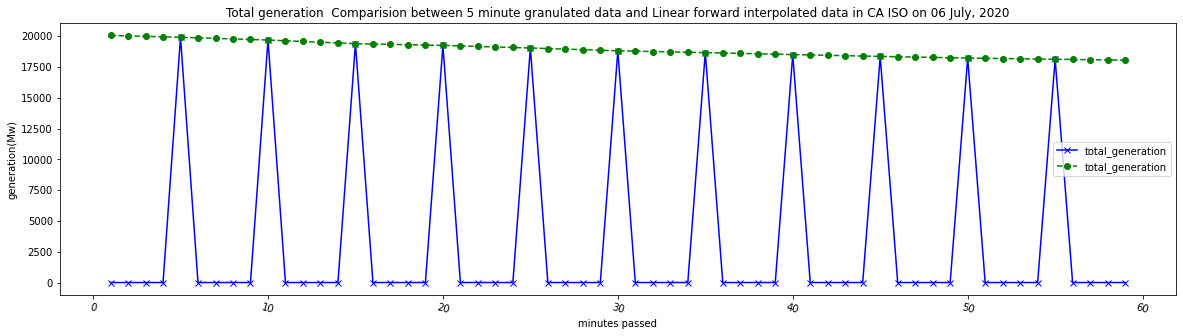

In [192]:
# difference in graphs for a single day

ax= df1_day.plot( x="MINUTES", y=["total_generation"], linestyle='-',marker='x', figsize=(20,5), color="Blue")
ax.set_prop_cycle(None)
df2_day.plot(  x="MINUTES", y=["total_generation"], ax = ax, linestyle='--',marker='o', figsize=(20,5), color="Green")

ax.set_title("Total generation  Comparision between 5 minute granulated data and Linear forward interpolated data in "
            + Region + " on "+ datetime.date(2020, 7, 6).strftime('%d %B, %Y'))
ax.set_ylabel("generation(Mw)")
ax.set_xlabel("minutes passed")
ax.set_ylim(bottom = 17500,top=39000)
plt.xticks(rotation=-15) 


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text major ticklabel objects>)

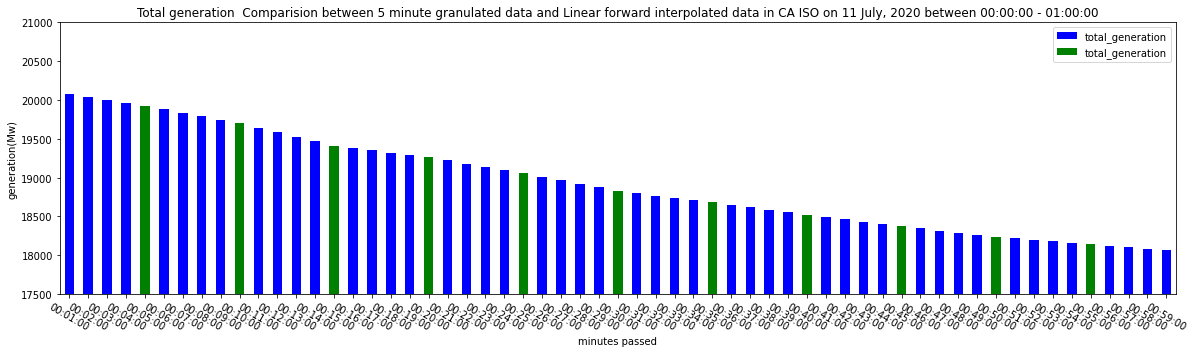

In [208]:
ax= df2_day.plot.bar( x="TIME", y=["total_generation"], figsize=(20,5), color="Blue")
df1_day.plot.bar(x="TIME", y=["total_generation"],ax = ax, figsize=(20,5), color="Green")

ax.set_title("Total generation  Comparision between 5 minute granulated data and Linear forward interpolated data in "
            + Region + " on "+ selectdate.strftime('%d %B, %Y')+ " between "+ starttime.strftime('%T') + " - "+ endtime.strftime('%T'))
ax.set_ylabel("generation(Mw)")
ax.set_xlabel("minutes passed")
ax.set_ylim(bottom = 17500,top=21000)
plt.xticks(rotation=-30) 
# plt.grid(True, which='both')
# plt.minorticks_on()


**Comparision between 5 minute granulated data and Pad forward interpolated data**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text major ticklabel objects>)

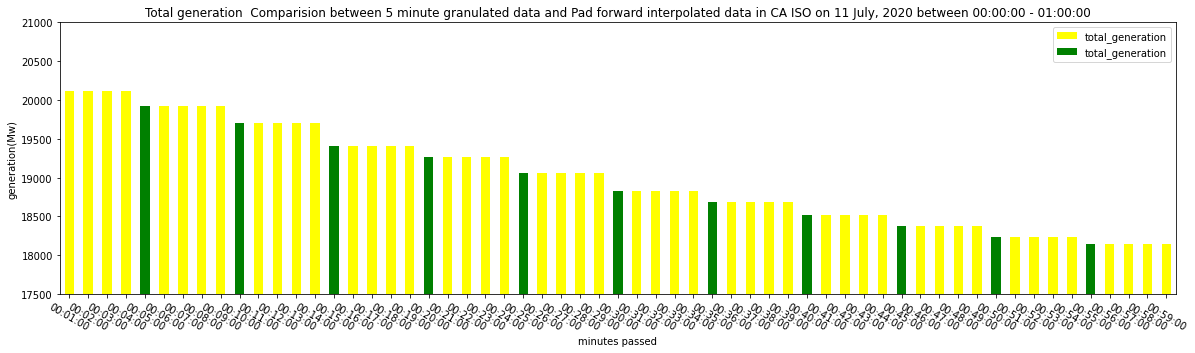

In [209]:
ax= df3_day.plot.bar( x="TIME", y=["total_generation"], figsize=(20,5), color="Yellow")
df1_day.plot.bar(x="TIME", y=["total_generation"],ax = ax, figsize=(20,5), color="Green")

ax.set_title("Total generation  Comparision between 5 minute granulated data and Pad forward interpolated data in "
            + Region + " on "+ selectdate.strftime('%d %B, %Y')+ " between "+ starttime.strftime('%T') + " - "+ endtime.strftime('%T'))
ax.set_ylabel("generation(Mw)")
ax.set_xlabel("minutes passed")
ax.set_ylim(bottom = 17500,top=21000)
plt.xticks(rotation=-30) 
# plt.grid(True, which='both')
# plt.minorticks_on()

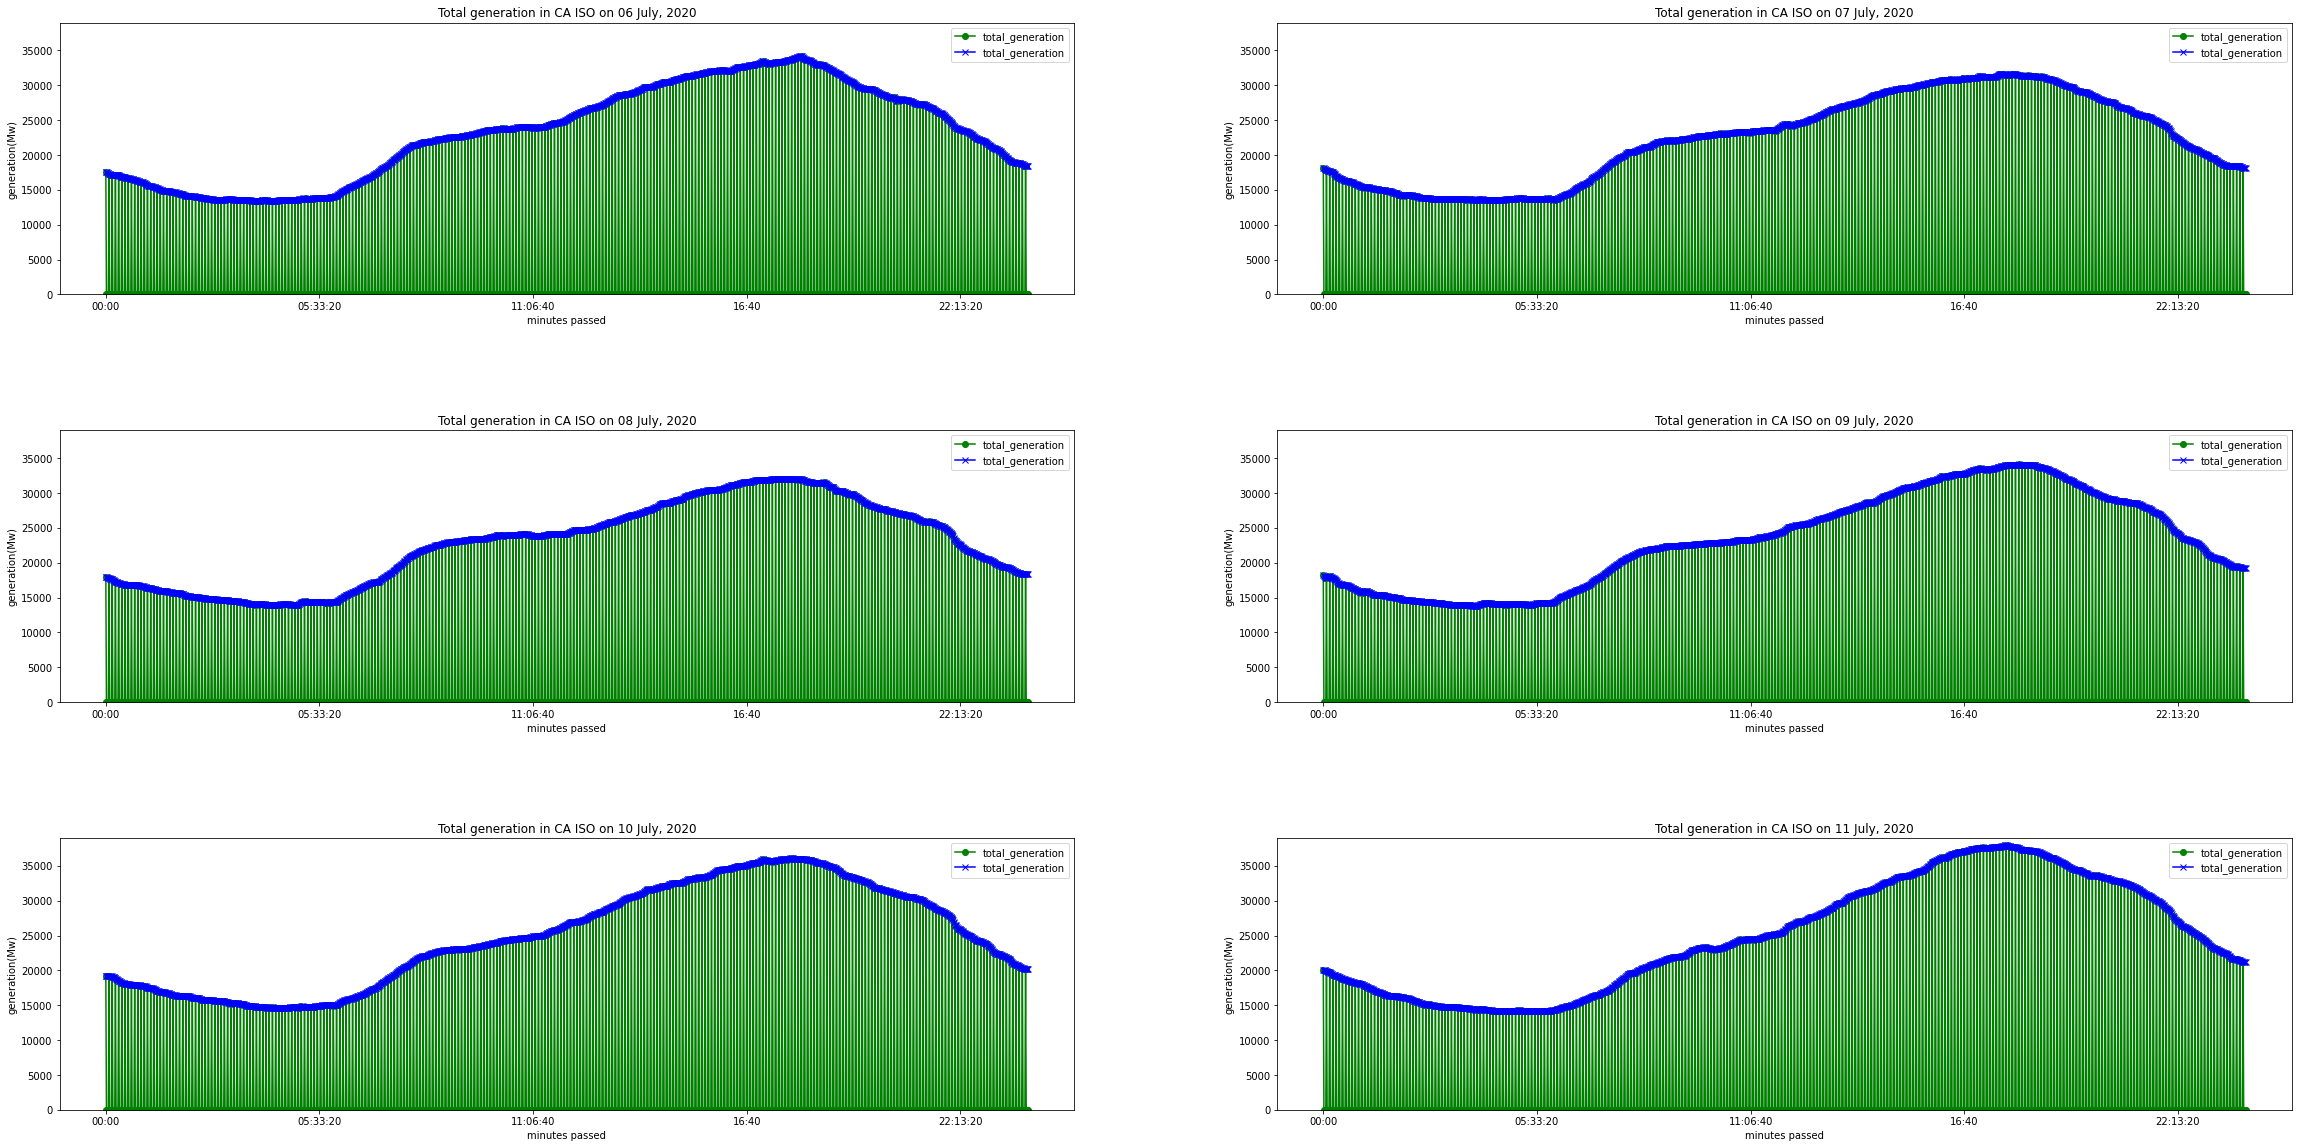

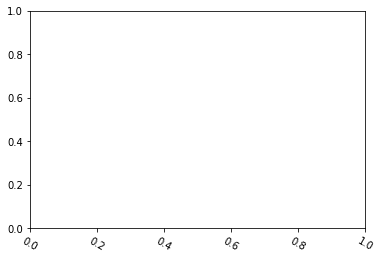

In [205]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(40, 20)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)

fig = plt.figure()
plt.xticks(rotation=-30) 

for pp,ax in zip(dates, axs.flatten()):

  df1[df1['DATE']==pp].plot( x="TIME", y=["total_generation"], linestyle='-',marker='o', ax = ax, color="Green")
  df2[df2['DATE']==pp].plot( x="TIME", y=["total_generation"], linestyle='-',marker='x', ax = ax, color="Blue")

  ax.set_title("Total generation in "+ Region + " on "+ pp.strftime('%d %B, %Y'))
  ax.set_ylabel("generation(Mw)")
  ax.set_xlabel("minutes passed")
  ax.set_ylim(bottom = 0,top=39000)
  

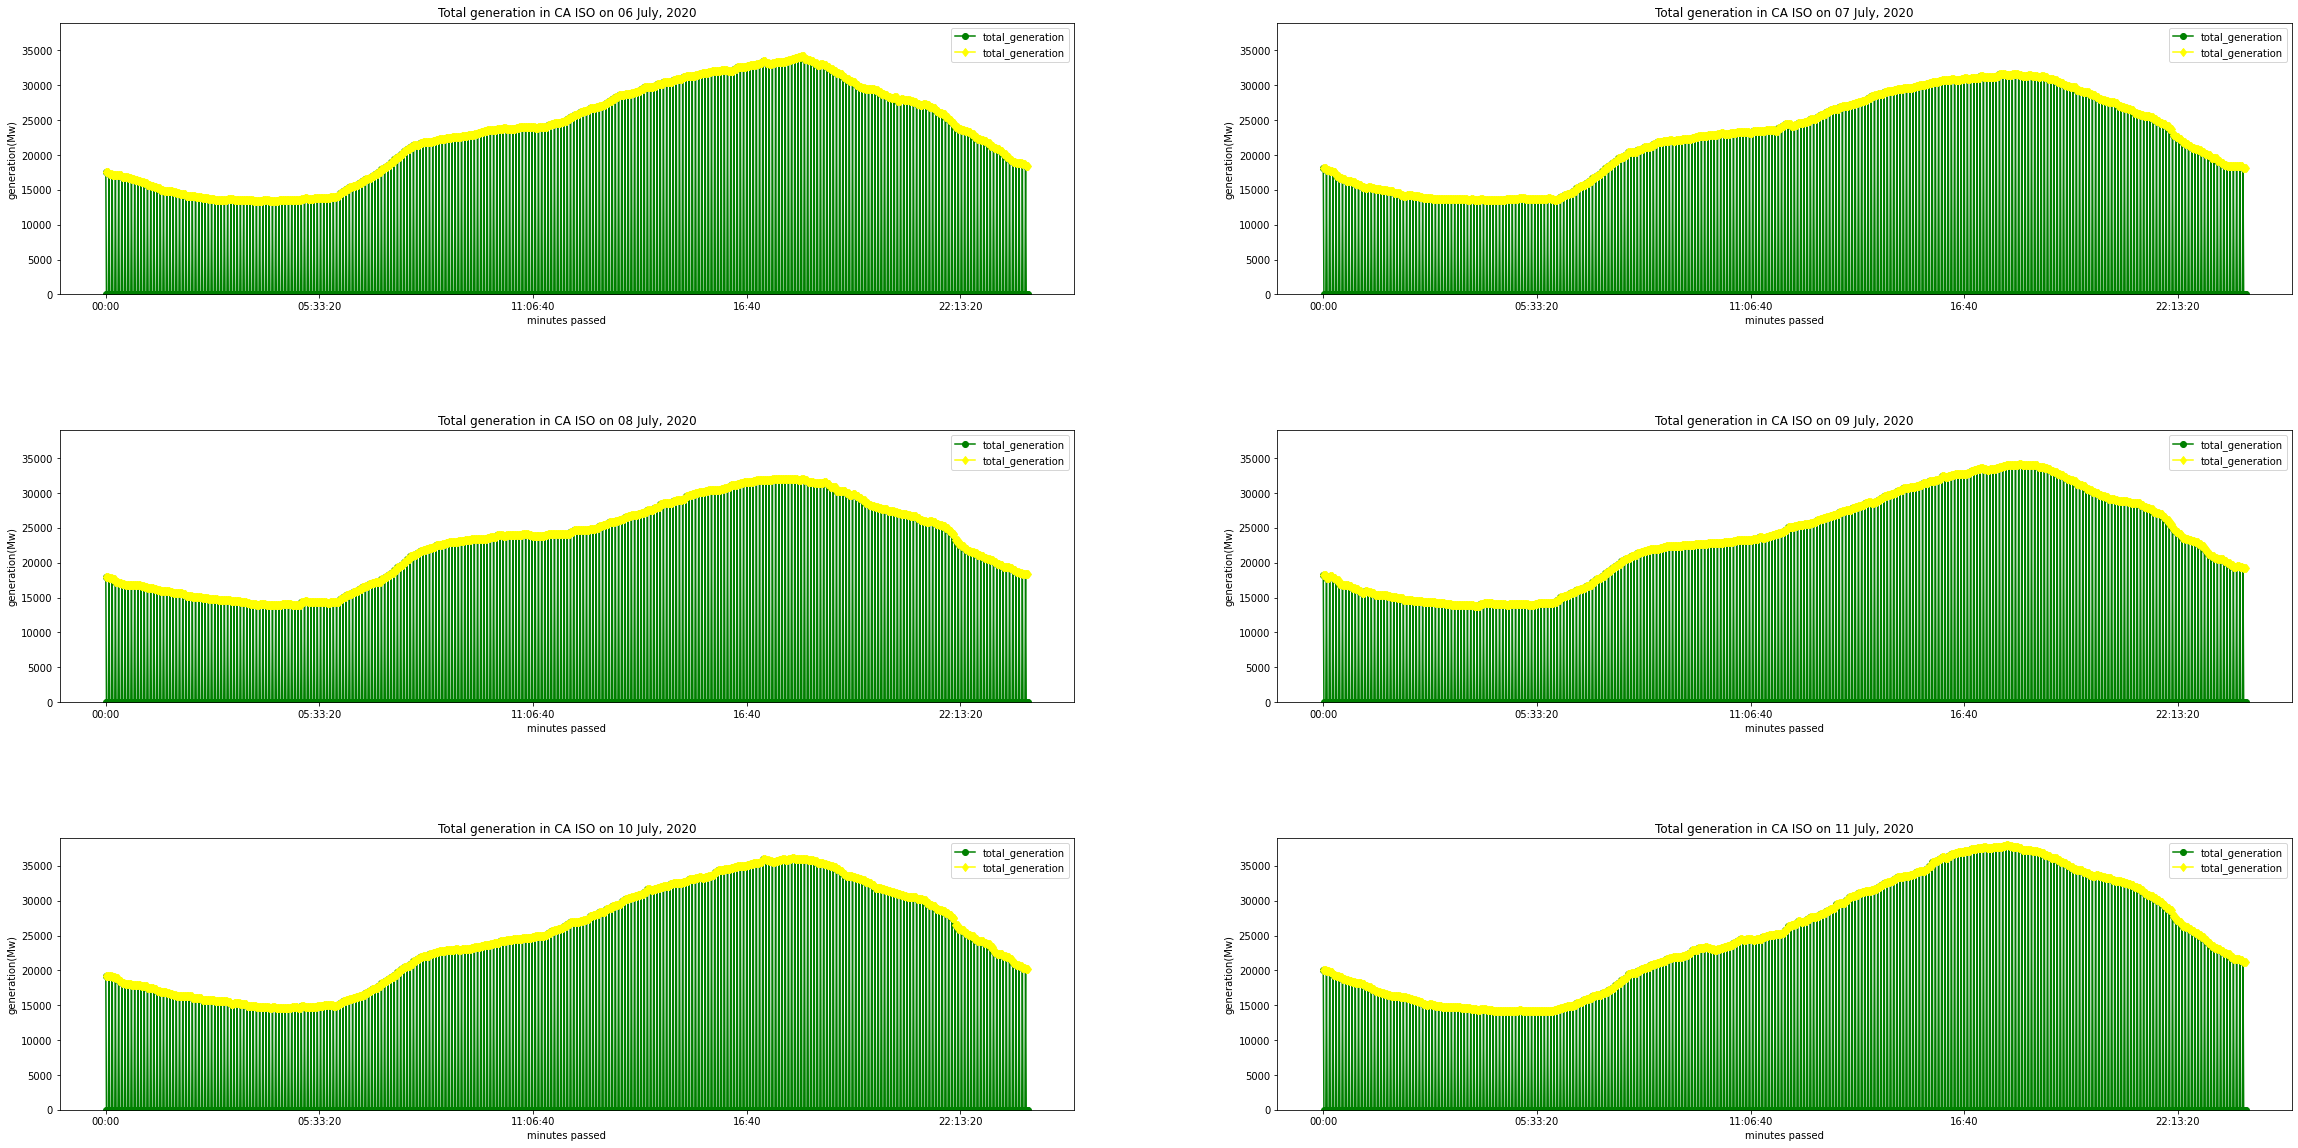

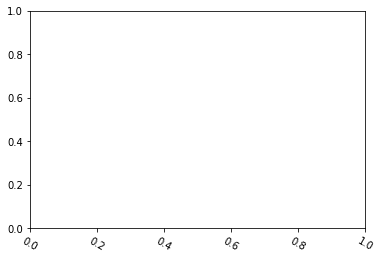

In [196]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(40, 20)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)

fig = plt.figure()
plt.xticks(rotation=-30) 

for pp,ax in zip(dates, axs.flatten()):

  df1[df1['DATE']==pp].plot(x='TIME', y=["total_generation"], linestyle='-',marker='o', ax = ax, color="Green")
  df3[df3['DATE']==pp].plot(x='TIME', y=["total_generation"], linestyle='-',marker='d', ax = ax, color="Yellow")

  ax.set_title("Total generation in "+ Region + " on "+ pp.strftime('%d %B, %Y'))
  ax.set_ylabel("generation(Mw)")
  ax.set_xlabel("minutes passed")
  ax.set_ylim(bottom = 0,top=39000)

## Daily chart for the week 

In [197]:
# fig, axs = plt.subplots(nrows=3, ncols=2)
# fig.set_size_inches(20, 10)
# fig.subplots_adjust(wspace=0.2)
# fig.subplots_adjust(hspace=0.5)

# fig.legend(column_list)

    
# for pp,ax in zip(dates,axs.flatten()):
# #     print(df_nw[pp])
#     print(pp)
#     sub_df = df[df['DATE']==pp]
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[0], ax = ax, title = "Fuel Mix for generation in "+ Region + " on "+ pp.strftime('%B %d, %Y'),legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[1], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[2], ax = ax,legend=False)    
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[3], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[4], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[5], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[6], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[7], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y =['total_generation'], ax = ax,legend=False)
    
#     ax.set_ylabel("generation(Mw)")
    
#     mean_gen = round(sub_df["total_generation"].mean())
#     max_gen = sub_df["total_generation"].max()
#     maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
#     maxh = maxh["MINUTES_PASS"]
#     ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
    
#     ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

# #     ax.get_legend().remove()
    
# #     ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
# #              arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)
    
#     ax.set_ylim(bottom = 0,top=39000)
    
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [198]:
# # Line Chart ( Trend during the day)
# plt = df.plot.line(x='HOURS',
#                     y = column_list,
#                     title = "Generation in "+ Region + " on "+ Date)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [199]:
# usage in one day 
# df_nw.plot(x='HOURS',  kind='hist')

# df_nw.plot(x='HOURS', y=["Wind Generation (MWh)","Solar Generation (MWh)","Hydro Generation (MWh)","Other Generation (MWh)", 
#                         "Petroleum Generation (MWh)", "Natural gas Generation (MWh)","Coal Generation (MWh)","Nuclear Generation (MWh)"], kind='hist')